In [171]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


videos = list(Path("../data/tmp/clips").glob("**/*.mp4"))

In [172]:
def get_frames(cap):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame


def get_subset(img, threshold=0.9):
    img = img[630:700, :400]

    # lets binarize based on closeness to white
    t = 255 * threshold
    img = cv2.inRange(img, (t, t, t), (255, 255, 255), img)
    img = cv2.bitwise_not(img)

    # lets also flood fill the background with black from corners
    n = img.shape[0]
    corners = [(0, 0), (0, n - 1), (n - 1, 0), (n - 1, n - 1)]
    for corner in corners:
        cv2.floodFill(img, None, corner, 0)

    # erode the text
    kernel = np.ones((2, 2), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    return img


video = [v for v in videos if "shime-waza_00" in v.name][0]
cap = cv2.VideoCapture(video.as_posix())
frames = []
for frame in tqdm(get_frames(cap)):
    subset = get_subset(frame)
    frames.append(subset)

0it [00:00, ?it/s]

391it [00:00, 744.53it/s]


In [173]:
import pytesseract

pytesseract.image_to_string(frames[25]).strip()

'Nami-juji-jime'

In [174]:
whitelist = "abcdefghijklmnopqrstuvwxyz" + "ABCDEFGHIJKLMNOPQRSTUVWXYZ" + "-:"

mapping = {"koshi-waza": 0.7}

res = []
for video in tqdm(videos):
    name = video.parent.stem
    cap = cv2.VideoCapture(video.as_posix())
    for i, frame in enumerate(get_frames(cap)):
        if i > 10:
            subset = get_subset(frame, threshold=mapping.get(name, 0.9))
            break
    ocr = pytesseract.image_to_string(
        subset, config=f"-c tessedit_char_whitelist={whitelist}"
    )
    res.append((video, ocr, subset, frame))
    cap.release()

100%|██████████| 125/125 [00:12<00:00,  9.71it/s]


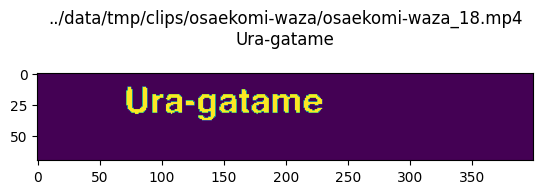

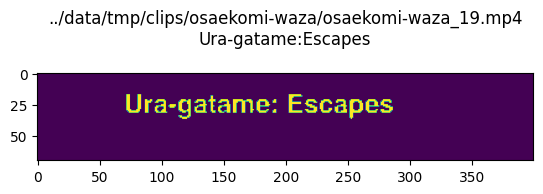

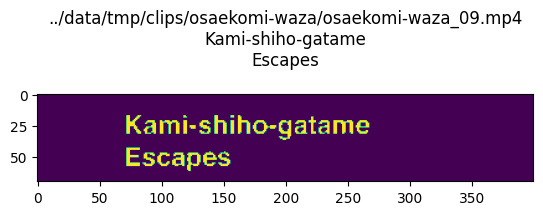

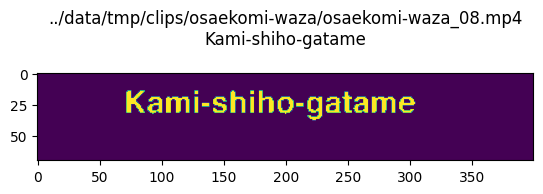

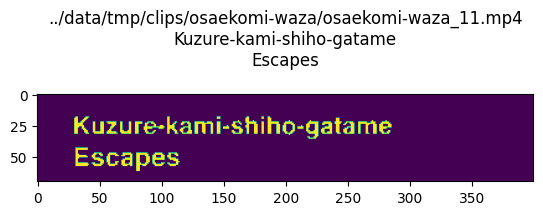

In [175]:
for path, ocr, frame, orig in res[:5]:
    plt.imshow(frame)
    plt.title(f"{path}\n{ocr}")
    plt.show()

In [178]:
def clean_text(text):
    text = text.strip().lower().replace("\n", " ").replace(" ", ":").replace("l", "i")
    if text.endswith("gatam"):
        text = text.replace("gatam", "gatame")
    return text


# create a final mapping that we can dump out yaml information
data = []
for path, ocr, frame, orig in sorted(res, key=lambda x: x[0]):
    data.append(
        {
            "path": path.relative_to("../data/tmp/clips").as_posix(),
            "ocr": clean_text(ocr),
        }
    )

for row in data:
    print("{}\t{}".format(row["path"], row["ocr"]))

ashi-waza/ashi-waza_00.mp4	de-ashi-harai
ashi-waza/ashi-waza_01.mp4	hiza-guruma
ashi-waza/ashi-waza_02.mp4	sasae-tsurikomi-ashi
ashi-waza/ashi-waza_03.mp4	o-soto-gari
ashi-waza/ashi-waza_04.mp4	o-uchi-gari
ashi-waza/ashi-waza_05.mp4	ko-soto-gari
ashi-waza/ashi-waza_06.mp4	ko-uchi-gari
ashi-waza/ashi-waza_07.mp4	okuri-ashi-harai
ashi-waza/ashi-waza_08.mp4	uchi-mata
ashi-waza/ashi-waza_09.mp4	ko-soto-gake
ashi-waza/ashi-waza_10.mp4	ashi-guruma
ashi-waza/ashi-waza_11.mp4	harai-tsurikomi-ashi
ashi-waza/ashi-waza_12.mp4	o-guruma
ashi-waza/ashi-waza_13.mp4	o-soto-guruma
ashi-waza/ashi-waza_14.mp4	o-soto-otoshi
ashi-waza/ashi-waza_15.mp4	tsubame-gaeshi
ashi-waza/ashi-waza_16.mp4	o-soto-gaeshi
ashi-waza/ashi-waza_17.mp4	o-uchi-gaeshi
ashi-waza/ashi-waza_18.mp4	hane-goshi-gaeshi
ashi-waza/ashi-waza_19.mp4	harai-goshi-gaeshi
ashi-waza/ashi-waza_20.mp4	uchi-mata-gaeshi
kansetsu-waza/kansetsu-waza_00.mp4	ude-garami
kansetsu-waza/kansetsu-waza_01.mp4	ude-hishigi-juji-gatame
kansetsu-waza/kansetsu-w

In [177]:
from itertools import groupby
import shutil

dest = Path("../data/clips")
dest.mkdir(exist_ok=True, parents=True)
for key, group in groupby(
    sorted(res, key=lambda x: x[0].stem), lambda x: x[0].parent.stem
):
    for i, item in enumerate(group):
        path, text, _, _ = item
        text = clean_text(text)
        if text:
            # rename the file
            new_name = f"{key}_{i:02d}_{text}.mp4"
            new_path = dest / new_name
        else:
            continue
        # copy the file to the new path
        shutil.copy(path, new_path)
        print(new_path)

../data/clips/ashi-waza_00_de-ashi-harai.mp4
../data/clips/ashi-waza_01_hiza-guruma.mp4
../data/clips/ashi-waza_02_sasae-tsurikomi-ashi.mp4
../data/clips/ashi-waza_03_o-soto-gari.mp4
../data/clips/ashi-waza_04_o-uchi-gari.mp4
../data/clips/ashi-waza_05_ko-soto-gari.mp4
../data/clips/ashi-waza_06_ko-uchi-gari.mp4
../data/clips/ashi-waza_07_okuri-ashi-harai.mp4
../data/clips/ashi-waza_08_uchi-mata.mp4
../data/clips/ashi-waza_09_ko-soto-gake.mp4
../data/clips/ashi-waza_10_ashi-guruma.mp4
../data/clips/ashi-waza_11_harai-tsurikomi-ashi.mp4
../data/clips/ashi-waza_12_o-guruma.mp4
../data/clips/ashi-waza_13_o-soto-guruma.mp4
../data/clips/ashi-waza_14_o-soto-otoshi.mp4
../data/clips/ashi-waza_15_tsubame-gaeshi.mp4
../data/clips/ashi-waza_16_o-soto-gaeshi.mp4
../data/clips/ashi-waza_17_o-uchi-gaeshi.mp4
../data/clips/ashi-waza_18_hane-goshi-gaeshi.mp4
../data/clips/ashi-waza_19_harai-goshi-gaeshi.mp4
../data/clips/ashi-waza_20_uchi-mata-gaeshi.mp4
../data/clips/kansetsu-waza_00_ude-garami.mp4